In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# parameters
N = 256   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w1 = Normal(loc=tf.zeros([D, 256]), scale=tf.ones([D, 256]))
b1 = Normal(loc=tf.zeros(256), scale=tf.ones(256))
l1 = tf.nn.leaky_relu(tf.matmul(x,w1)+b1)

w2 = Normal(loc=tf.zeros([256, 256]), scale=tf.ones([256, 256]))
b2 = Normal(loc=tf.zeros(256), scale=tf.ones(256))
l2 = tf.nn.leaky_relu(tf.matmul(l1,w2)+b2)

w3 = Normal(loc=tf.zeros([256, K]), scale=tf.ones([256, K]))
b3 = Normal(loc=tf.zeros(K), scale=tf.ones(K))

# Categorical likelihood for classication.
y = Categorical(tf.matmul(l2,w3)+b3)

In [4]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw1 = Normal(loc=tf.Variable(tf.random_normal([D, 256])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 256]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([256])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([256, 256])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([256, 256]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([256])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qw3 = Normal(loc=tf.Variable(tf.random_normal([256, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([256, K]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))


In [5]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])

# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w1: qw1, b1: qb1, w2: qw2, b2: qb2, w3: qw3, b3: qb3}, data={y:y_ph})

# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [6]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)


5000/5000 [100%] ██████████████████████████████ Elapsed: 21s | Loss: 2470905.000


In [7]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
w1_samples = []
b1_samples = []
w2_samples = []
b2_samples = []
w3_samples = []
b3_samples = []

In [8]:
for i in range(n_samples):
    w1_samp = qw1.sample()
    b1_samp = qb1.sample()
    w2_samp = qw2.sample()
    b2_samp = qb2.sample()
    w3_samp = qw3.sample()
    b3_samp = qb3.sample()

    w1_samples.append(w1_samp)
    b1_samples.append(b1_samp)
    w2_samples.append(w2_samp)
    b2_samples.append(b2_samp)
    w3_samples.append(w3_samp)
    b3_samples.append(b3_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    l1_samp = tf.nn.leaky_relu(tf.matmul( X_test,w1_samp ) + b1_samp)
    l2_samp = tf.nn.leaky_relu(tf.matmul( l1_samp,w2_samp ) + b2_samp)
    l3_samp = tf.matmul( l2_samp,w3_samp ) + b3_samp
        
    prob = tf.nn.softmax(l3_samp)
    prob_lst.append(prob.eval())
    if not (i+1)%10:
        print(i+1, "steps completed.")

10 steps completed.
20 steps completed.
30 steps completed.
40 steps completed.
50 steps completed.
60 steps completed.
70 steps completed.
80 steps completed.
90 steps completed.
100 steps completed.


In [15]:
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()

print("Expactation of Accuracy: ", sess.run(tf.reduce_mean(accy_test)))

Expactation of Accuracy:  0.9352283


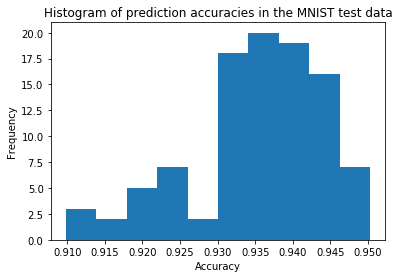

In [16]:
plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [11]:
not_mnist = input_data.read_data_sets("./notMNIST_data/", one_hot=True)

Extracting ./notMNIST_data/train-images-idx3-ubyte.gz
Extracting ./notMNIST_data/train-labels-idx1-ubyte.gz
Extracting ./notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./notMNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
# Load the test images from the data and their lables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

truth =  3
float32


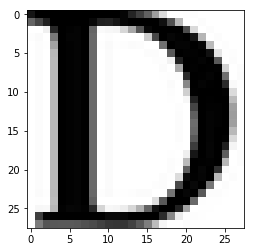

In [32]:
# Load the first image from the notMNIST.
test_image = Xnm_test[0]
test_label = Ynm_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='binary')

In [34]:
nm_sing_img_probs = []
for i in range(n_samples):
    w1_samp=w1_samples[i]
    w2_samp=w2_samples[i]
    w3_samp=w3_samples[i]
    b1_samp=b1_samples[i]
    b2_samp=b2_samples[i]
    b3_samp=b3_samples[i]
    
    
    l1_samp = tf.nn.leaky_relu(tf.matmul( Xnm_test[0:1],w1_samp ) + b1_samp)
    l2_samp = tf.nn.leaky_relu(tf.matmul( l1_samp,w2_samp ) + b2_samp)
    l3_samp = tf.matmul( l2_samp,w3_samp ) + b3_samp
    
    prob = tf.nn.softmax(l3_samp)
    nm_sing_img_probs.append(prob.eval())
    if not (i+1)%10:
        print(i+1, "steps completed.")

10 steps completed.
20 steps completed.
30 steps completed.
40 steps completed.
50 steps completed.
60 steps completed.
70 steps completed.
80 steps completed.
90 steps completed.
100 steps completed.


Text(0,0.5,'Frequency')

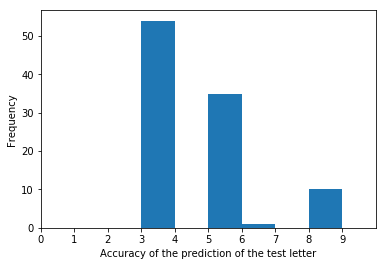

In [35]:
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")

In [12]:
# Load the test images from the data and their lables. 
Xm_test = mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ym_test = np.argmax(mnist.test.labels,axis=1)

truth =  7


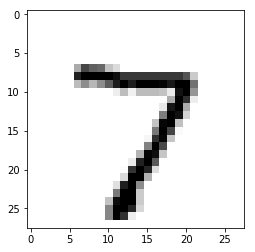

In [13]:
# Load the first image from the notMNIST.
test_image = Xm_test[0]
test_label = Ym_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='binary')

In [14]:
nm_sing_img_probs = []
for i in range(n_samples):
    w1_samp=w1_samples[i]
    w2_samp=w2_samples[i]
    w3_samp=w3_samples[i]
    b1_samp=b1_samples[i]
    b2_samp=b2_samples[i]
    b3_samp=b3_samples[i]
    
    
    l1_samp = tf.nn.leaky_relu(tf.matmul( Xm_test[0:1],w1_samp ) + b1_samp)
    l2_samp = tf.nn.leaky_relu(tf.matmul( l1_samp,w2_samp ) + b2_samp)
    l3_samp = tf.matmul( l2_samp,w3_samp ) + b3_samp
    
    prob = tf.nn.softmax(l3_samp)
    nm_sing_img_probs.append(prob.eval())
    if not (i+1)%10:
        print(i+1, "steps completed.")

10 steps completed.
20 steps completed.
30 steps completed.
40 steps completed.
50 steps completed.
60 steps completed.
70 steps completed.
80 steps completed.
90 steps completed.
100 steps completed.


Text(0,0.5,'Frequency')

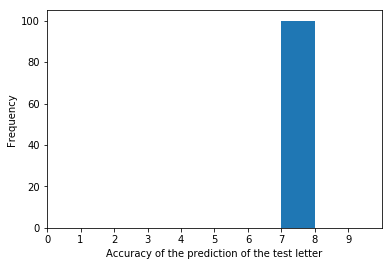

In [15]:
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")